In [1]:
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

from sktime.distances import dtw_distance
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from tslearn.clustering import TimeSeriesKMeans
from plotly.subplots import make_subplots

pio.renderers.default = "browser"





In [2]:
# #resample the data
# df = pd.read_parquet('data/1-22.02.2023_tempdata.parquet')
# trimmed_data = pd.DataFrame()
# iter = 0
# res_list = []
# for elem in df['hostname'].unique():
#     df_temp = df[df['hostname'] == elem]
#     df_res = df_temp.resample('10min', on='date').mean()
#     df_res = df_res.dropna(thresh=2)
#     size = len(df_res['cpu1'].values)
#     temp_series = pd.Series([elem], name='hostname').repeat(size)
#     df_res.loc[:, 'hostname'] = temp_series.values
#     print("done: ", iter, "in: ", len(df['hostname'].unique()))
#     res_list.append(df_res)
#     iter += 1

# trimmed_data = pd.concat(res_list, axis=0)


# trimmed_data.info()
# trimmed_data.to_parquet('1-22.02.2023_tempdata_trimmed.parquet')

In [2]:

df_trimmed = pd.read_parquet('data/1-22.02.2023_tempdata_trimmed.parquet')
df_trimmed['date'] = pd.to_datetime(df_trimmed['date'])
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002123 entries, 0 to 2002122
Data columns (total 10 columns):
 #   Column      Dtype                               
---  ------      -----                               
 0   date        datetime64[ns, pytz.FixedOffset(60)]
 1   cpu1        float64                             
 2   cpu2        float64                             
 3   power       float64                             
 4   kiosk       float64                             
 5   rack        float64                             
 6   chassis     float64                             
 7   blade       float64                             
 8   cpus_alloc  float64                             
 9   hostname    object                              
dtypes: datetime64[ns, pytz.FixedOffset(60)](1), float64(8), object(1)
memory usage: 152.7+ MB


In [3]:
df_trimmed_one_day = df_trimmed[df_trimmed['date'].dt.date == datetime.date(2023, 2, 6)]
x = []
for elem in df_trimmed_one_day['hostname'].unique():
    df_temp = df_trimmed_one_day[df_trimmed_one_day['hostname'] == elem]
    if len(df_temp['power']) == 144: #choose only full days of data
        res = df_temp['power'].reset_index(drop=True)
        res.name=elem
        x.append(res)



          e1408     e1264     e1723     e1993     e1247     e1810     e1216  \
e1408  1.000000 -0.128369  0.041951  0.061838 -0.000480 -0.021481  0.101930   
e1264 -0.128369  1.000000  0.100278  0.120972 -0.085134 -0.092681  0.173615   
e1723  0.041951  0.100278  1.000000  0.048631  0.038230  0.082404  0.117155   
e1993  0.061838  0.120972  0.048631  1.000000  0.024896  0.059335  0.054278   
e1247 -0.000480 -0.085134  0.038230  0.024896  1.000000 -0.090154  0.069453   
...         ...       ...       ...       ...       ...       ...       ...   
e2349  0.057396 -0.037681  0.214981 -0.082896  0.008022  0.076193  0.158810   
e2354  0.078084 -0.049539  0.237469 -0.052348  0.010861  0.059391  0.148762   
e2356  0.059315 -0.074398  0.192330 -0.048597  0.038769  0.012568  0.098673   
e2073 -0.047926 -0.072159  0.050462  0.032853 -0.000001  0.113711  0.048466   
e2080 -0.092053 -0.053132  0.023877  0.050358 -0.100694  0.004777 -0.078277   

          e1235     e1237     e1234  ...     e2357 

<AxesSubplot:>

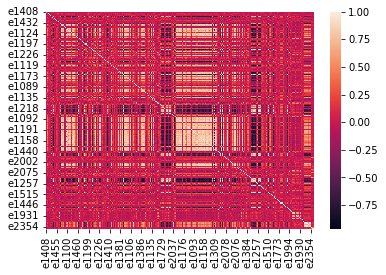

In [5]:
distance_matrix = pd.concat([series for series in x], axis=1).corr()
print(distance_matrix)
sns.heatmap(distance_matrix)

In [5]:
x_ = np.reshape(x, (np.shape(x)[0], np.shape(x)[1], 1))
print(np.shape(x_))

(304, 144, 1)


In [7]:
n_clusters = 8
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
model.fit(x_)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=8)

In [8]:

fig = make_subplots(rows=n_clusters/2, cols=2)
for i in range(0,n_clusters):
    print(i//2+1, i%2+1)
    for j, label in enumerate(model.labels_):
        if i == label:
            fig.add_trace(go.Scatter(y = x[j], mode="lines"), row=i//2+1, col=i%2+1)


fig.show()

1 1
1 2
2 1
2 2
3 1
3 2
4 1
4 2


In [37]:
#DBSCAN
from tslearn.metrics.dtw_variants import cdist_dtw

cdist = cdist_dtw(x_, n_jobs=-1, verbose=1)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 8354 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 11154 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 12704 task

In [54]:
from sklearn.cluster import DBSCAN
import plotly.express as px
from sklearn.preprocessing import Normalizer

norm = Normalizer()
cdist = norm.fit_transform(cdist)

dbscan_model = DBSCAN(eps=0.002, min_samples=3, metric="precomputed").fit(cdist)
print('computed')
labels = dbscan_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

fig = make_subplots(rows=n_clusters_//2+1, cols=2)
for i in range(-1,n_clusters_):
    if i == -1:
        for j, label in enumerate(dbscan_model.labels_):
            fig.add_trace(go.Scatter(y = x[j], mode="lines"), row=n_clusters_//2+1, col=2)
    else:
        print(i//2+1, i%2+1)
        for j, label in enumerate(dbscan_model.labels_):
            
            if i == label:
                fig.add_trace(go.Scatter(y = x[j], mode="lines"), row=i//2+1, col=i%2+1)


fig.show()


computed
Estimated number of clusters: 7
Estimated number of noise points: 104
1 1
1 2
2 1
2 2
3 1
3 2
4 1


In [55]:
print(set(labels))

{0, 1, 2, 3, 4, 5, 6, -1}
